# Multi-Floor Plan Detection & Analysis

This notebook develops comprehensive prompts for Gemini to:
1. Detect if a floor plan image contains multiple floors
2. Identify each floor level (basement, main, second, third, attic)
3. Extract room data for each floor separately
4. Handle various floor plan layouts and styles

In [1]:
# Setup: libraries, API key, and output paths
import os, json, re, mimetypes, time
from datetime import datetime
from pathlib import Path
from typing import Any, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    HAVE_WIDGETS = True
except Exception:
    HAVE_WIDGETS = False

from dotenv import load_dotenv
import google.generativeai as genai

# Load environment and configure Gemini
load_dotenv()
API_KEY = os.getenv("GOOGLE_API_KEY") or os.getenv("GOOGLE_GENAI_API_KEY")
if not API_KEY:
    raise RuntimeError("Missing GOOGLE_API_KEY. Set it in your environment or a .env file.")

genai.configure(api_key=API_KEY)

# Model selection: default to a widely available Flash vision model; override with GEMINI_MODEL if set
MODEL_NAME = os.getenv("GEMINI_MODEL", "gemini-2.5-flash")
model = genai.GenerativeModel(MODEL_NAME)

# Output directory for analysis artifacts
OUTPUT_DIR = Path("..") / "uploads" / "floor_plans" / "analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Helper: read image bytes and mime type
def read_image_bytes(path: str) -> Tuple[bytes, str]:
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    mime, _ = mimetypes.guess_type(str(p))
    if mime is None:
        # Default to PNG if unknown
        mime = "image/png"
    with open(p, "rb") as f:
        data = f.read()
    return data, mime

print(f"Gemini model ready: {MODEL_NAME}")
print(f"Artifacts will be saved under: {OUTPUT_DIR.resolve()}")

Gemini model ready: gemini-2.5-flash
Artifacts will be saved under: C:\Users\ramma\Documents\augment-projects\augment\uploads\floor_plans\analysis


In [ ]:
# Comprehensive multi-floor prompt (v2, 3ST-driven, scale-aware)
multi_floor_prompt = """
# MULTI-FLOOR PLAN ANALYSIS TASK (v2)

You are an expert architectural floor plan analyzer. Analyze the provided floor plan image and return only valid JSON per the schema below. Your goals:
1) Detect if the image shows SINGLE or MULTIPLE floors.
2) Segment each floor section and identify its level (basement, main, second, third, attic).
3) Extract rooms with accurate dimensions and areas, plus walls, doors, windows, stairs, texts, and adjacency.
4) Return robust metadata for storage: units, scale, pixel-to-unit, section bounding boxes, confidence, warnings.

USE 3ST FEATURES THROUGHOUT
- Semantic (labels/symbols/text): floor labels (BASEMENT, MAIN, SECOND), room names/abbreviations, furniture/fixtures, utility symbols (furnace, panel).
- Spatial/Topology: wall/door/window graph, enclosed room polygons, adjacency (room-to-room, door connects), stair continuity between floors.
- Shape/Texture: exterior vs interior wall thickness, hatch for unfinished areas (basement/attic), line styles for openings, stair arrow direction, door swing arcs.

OCR & TEXT PARSING
- Extract all text and symbols relevant to floors/rooms/dimensions/scale.
- Recognize room labels (examples, not exhaustive): 
  KIT/KITCHEN, LIV/LIVING, DIN/DINING, FAM/FAMILY, BED/BR/BEDROOM, PRIMARY/MASTER, BATH/BA, 1/2 BATH/POWDER, WIC, CLO/CLOSET, LAUN/LDY, MUD, PAN/PANTRY, OFF/OFFICE, REC/RECREATION, MECH/UTILITY, STOR/STORAGE, GAR/GARAGE, FOY/ENTRY, LOFT, ATTIC.
- Dimension patterns (imperial): 12'-6", 12’ 6”, 12-6, 12'6", 12' x 10', 12-6 x 10-0; Area: 120 SQ FT, 120 SF.
- Dimension patterns (metric): 3.5 m, 3500 mm, 3.5×4.0 m; Area: 11.2 m², 11.2 sqm.
- Scale patterns: 
  - Imperial: Scale 1/4" = 1'-0", 3/16"=1'-0"
  - Metric: Scale 1:50, 1:100, Scale Bar.

UNITS & SCALE RESOLUTION
- Detect units: "imperial" (ft/in) or "metric" (m/mm).
- Parse scale text if present. If absent, infer scale via robust heuristics (use multiple): 
  - Standard door leaf ≈ 3 ft (0.91 m)
  - Standard tub ≈ 5 ft (1.52 m)
  - Standard stair tread depth ≈ 10–11 in (250–280 mm)
  - Standard queen bed ≈ 60 in × 80 in (1.52×2.03 m)
- Compute pixel_to_unit (e.g., pixels_per_foot or pixels_per_meter) per floor section. Report inference source.

SECTIONING MULTI-FLOOR IMAGES
- If multiple floors in one image, segment by borders/whitespace/layout blocks. Produce a section_bbox for each floor in image coordinates.
- Analyze each section independently; maintain per-floor pixel_to_unit (they can differ due to scanning).

WALLS, DOORS, WINDOWS, STAIRS
- Walls: vectorize as polylines; include thickness estimate (pixels and units), interior/exterior classification if possible.
- Doors: detect swing arcs or door symbols; width; connected rooms; type (entry, interior, sliding, french, pocket).
- Windows: type (standard, bay, picture, casement), count, span length.
- Stairs: type (straight, L, U, spiral), arrow direction (up/down), connects_to_floor, riser count if visible.

ROOM POLYGONS & DIMENSIONS
- Prefer room polygons (list of (x,y) vertices) over bounding boxes for area calculations.
- Dimension priority:
  1) Use explicit OCR dimensions for that room if present (source="ocr").
  2) Otherwise compute from polygon geometry and pixel_to_unit (source="scale").
  3) If scale is uncertain, estimate from typical sizes (source="estimate") and set estimated=true.
- Report: length, width, perimeter, area; include unit fields and source; include centroid for each room.

SPATIAL GRAPH & ADJACENCY
- Build adjacency edges room<->room via doors/openings; room<->stair; room<->exterior.
- Validate door connects to two regions; flag if door floats (no connection).

ROBUSTNESS & EDGE CASES
- Handle: rotated plans, scans with noise/blur, unlabeled floors, partial floors, split-levels, duplexes/units within one sheet.
- If ambiguous floor level, infer from semantics (kitchen→main, bedrooms cluster→upper, utilities→basement) and note reasoning.

QUALITY & CONSISTENCY CHECKS
- Validate: polygons are inside their floor section; door widths reasonable (2–4 ft), interior wall thickness ~4–6 in, exterior ~6–10 in (imperial) or metric equivalents.
- Sum of room areas ≲ floor total area; flag discrepancies.
- Confidence scoring per floor and per entity; include warnings[] and errors[] if issues found.

OUTPUT SCHEMA (RETURN ONLY JSON)
Return exactly one JSON object matching this schema. Do not include any extra commentary.

```json
{
  "schema_version": "2.0",
  "image_info": {
    "width_px": <int>,
    "height_px": <int>,
    "orientation_deg": <0|90|180|270>
  },
  "units": {
    "system": "imperial|metric",
    "length_unit": "ft|in|m|mm",
    "area_unit": "sqft|sqm",
    "scale_text": "<raw scale text or null>"
  },
  "floor_plan_type": "single_floor|multi_floor",
  "total_floors_detected": <int>,
  "floors": [
    {
      "floor_number": 0|1|2|3|99,
      "floor_name": "Basement|Main Floor|Second Floor|Third Floor|Attic",
      "floor_type": "basement|main|second|third|attic",
      "label_detected": "<exact text or 'inferred'>",
      "detection_confidence": <0.0-1.0>,
      "detection_reasoning": "<string>",
      "section_bbox": { "x_min": <int>, "y_min": <int>, "x_max": <int>, "y_max": <int> },
      "pixel_to_unit": {
        "pixels_per_foot": <float|null>,
        "pixels_per_meter": <float|null>,
        "inferred_from": "scale_text|door|tub|stair|bed|unknown"
      },
      "walls": [
        {
          "polyline": [[x,y], [x,y], ...],
          "thickness": { "pixels": <float>, "value": <float>, "unit": "in|mm|ft|m" },
          "type": "interior|exterior|unknown"
        }
      ],
      "doors": [
        {
          "type": "entry|interior|sliding|french|pocket|other",
          "swing": "left|right|none|unknown",
          "width": { "value": <float>, "unit": "ft|in|m|mm", "source": "ocr|scale|estimate" },
          "center": { "x": <int>, "y": <int> },
          "connects": ["<room_id_or_name>", "<room_id_or_name>"]
        }
      ],
      "windows": [
        {
          "type": "standard|bay|picture|casement|other",
          "span": { "value": <float>, "unit": "ft|m", "source": "ocr|scale|estimate" },
          "centerline": [[x,y],[x,y]],
          "room": "<room_id_or_name>"
        }
      ],
      "stairs": [
        {
          "type": "straight|L-shaped|U-shaped|spiral",
          "direction": "up|down|both",
          "connects_to_floor": 0|1|2|3|99,
          "polyline": [[x,y], [x,y], ...],
          "tread_count": <int|null>
        }
      ],
      "rooms": [
        {
          "id": "<stable_id>",
          "room_type": "kitchen|living_room|bedroom|bathroom|...|unknown",
          "name": "<friendly name>",
          "label_ocr": "<raw label text or null>",
          "polygon": [[x,y], [x,y], ...],
          "centroid": { "x": <int>, "y": <int> },
          "measured_dimensions": {
            "length": { "value": <float>, "unit": "ft|m", "source": "ocr|scale|estimate" },
            "width":  { "value": <float>, "unit": "ft|m", "source": "ocr|scale|estimate" },
            "perimeter": { "value": <float>, "unit": "ft|m" },
            "area": { "value": <float>, "unit": "sqft|sqm" },
            "estimated": <true|false>
          },
          "features": ["island","fireplace","pantry","double_sink","shower","tub","walk_in_closet", "..."],
          "confidence": <0.0-1.0>
        }
      ],
      "texts": [
        {
          "text": "<string>",
          "bbox": { "x_min": <int>, "y_min": <int>, "x_max": <int>, "y_max": <int> },
          "category": "floor_label|room_label|dimension|note|other"
        }
      ],
      "adjacency": [
        { "from": "<room_id>", "to": "<room_id>", "via": "door|opening|archway" }
      ],
      "floor_analysis": {
        "total_area": { "value": <float>, "unit": "sqft|sqm", "source": "sum_rooms|ocr|scale|estimate" },
        "room_count": <int>,
        "layout_type": "open_concept|traditional|split_level|other",
        "ceiling_height": { "value": <float|null>, "unit": "ft|m" },
        "notes": "<observations>"
      },
      "warnings": ["<string>", "..."],
      "errors": ["<string>", "..."]
    }
  ],
  "overall_analysis": {
    "home_style": "single_story|two_story|three_story|split_level|multi_unit|unknown",
    "has_basement": true|false,
    "has_attic": true|false,
    "totals": {
      "area": { "value": <float>, "unit": "sqft|sqm" },
      "rooms": <int>,
      "floors": <int>
    },
    "overall_confidence": <0.0-1.0>,
    "notes": "<overall observations>"
  }
}
```

CRITICAL INSTRUCTIONS
1) RETURN ONLY VALID JSON. No markdown or extra text.
2) DETECT & SEGMENT FLOORS first; provide section_bbox for each floor.
3) RESOLVE UNITS & SCALE; fill pixel_to_unit with source.
4) USE 3ST CUES to classify floors and rooms; explain reasoning briefly.
5) DIMENSIONS: prefer OCR, else compute via scale, else estimate and mark estimated=true.
6) VALIDATE with consistency checks; populate warnings/errors.
"""

print("\n" + "="*100)
print("COMPREHENSIVE MULTI-FLOOR DETECTION PROMPT (v2)")
print("="*100)
print(multi_floor_prompt[:2000] + "\n... (truncated for display)")
print("\n" + "="*100)
print(f"Prompt length: {len(multi_floor_prompt)} characters")
print(f"Estimated words: ~{len(multi_floor_prompt.split())}")


COMPREHENSIVE MULTI-FLOOR DETECTION PROMPT (v2)

# MULTI-FLOOR PLAN ANALYSIS TASK (v2)

You are an expert architectural floor plan analyzer. Analyze the provided floor plan image and return only valid JSON per the schema below. Your goals:
1) Detect if the image shows SINGLE or MULTIPLE floors.
2) Segment each floor section and identify its level (basement, main, second, third, attic).
3) Extract rooms with accurate dimensions and areas, plus walls, doors, windows, stairs, texts, and adjacency.
4) Return robust metadata for storage: units, scale, pixel-to-unit, section bounding boxes, confidence, warnings.

USE 3ST FEATURES THROUGHOUT
- Semantic (labels/symbols/text): floor labels (BASEMENT, MAIN, SECOND), room names/abbreviations, furniture/fixtures, utility symbols (furnace, panel).
- Spatial/Topology: wall/door/window graph, enclosed room polygons, adjacency (room-to-room, door connects), stair continuity between floors.
- Shape/Texture: exterior vs interior wall thickness, hatch f


COMPREHENSIVE MULTI-FLOOR DETECTION PROMPT (v2)

# MULTI-FLOOR PLAN ANALYSIS TASK (v2)

You are an expert architectural floor plan analyzer. Analyze the provided floor plan image and return only valid JSON per the schema below. Your goals:
1) Detect if the image shows SINGLE or MULTIPLE floors.
2) Segment each floor section and identify its level (basement, main, second, third, attic).
3) Extract rooms with accurate dimensions and areas, plus walls, doors, windows, stairs, texts, and adjacency.
4) Return robust metadata for storage: units, scale, pixel-to-unit, section bounding boxes, confidence, warnings.

USE 3ST FEATURES THROUGHOUT
- Semantic (labels/symbols/text): floor labels (BASEMENT, MAIN, SECOND), room names/abbreviations, furniture/fixtures, utility symbols (furnace, panel).
- Spatial/Topology: wall/door/window graph, enclosed room polygons, adjacency (room-to-room, door connects), stair continuity between floors.
- Shape/Texture: exterior vs interior wall thickness, hatch f

In [3]:
# Utilities: JSON extraction/validation, Gemini call, visualization, and saving
import json
from json import JSONDecodeError

try:
    from json_repair import repair_json  # helps fix minor JSON formatting issues
    HAVE_JSON_REPAIR = True
except Exception:
    HAVE_JSON_REPAIR = False

# --- JSON helpers ---
def extract_json(text: str) -> Dict[str, Any]:
    """Extract the first valid JSON object from a text response.
    Tries direct parse, fenced code blocks, brute-force braces, and optional repair.
    """
    # 1) Direct parse
    try:
        return json.loads(text)
    except Exception:
        pass

    # 2) Strip common code fences
    fenced = re.sub(r"^```(json)?|```$", "", text.strip(), flags=re.MULTILINE)
    try:
        return json.loads(fenced)
    except Exception:
        pass

    # 3) Find the largest {...} block
    first = text.find('{')
    last = text.rfind('}')
    if first != -1 and last != -1 and last > first:
        candidate = text[first:last+1]
        try:
            return json.loads(candidate)
        except Exception:
            if HAVE_JSON_REPAIR:
                try:
                    fixed = repair_json(candidate)
                    return json.loads(fixed)
                except Exception:
                    pass

    # 4) Try full repair if available
    if HAVE_JSON_REPAIR:
        try:
            fixed = repair_json(text)
            return json.loads(fixed)
        except Exception:
            pass

    raise JSONDecodeError("Failed to extract JSON from model response", text, 0)


def light_validate(result: Dict[str, Any]) -> None:
    """Lightweight validation of critical fields; raises ValueError if missing."""
    required_top = ["schema_version", "units", "floor_plan_type", "floors"]
    for k in required_top:
        if k not in result:
            raise ValueError(f"Missing required field: {k}")
    if not isinstance(result["floors"], list) or len(result["floors"]) == 0:
        raise ValueError("'floors' must be a non-empty list")


# --- Gemini call ---
def call_gemini_and_parse(image_path: str, prompt: str) -> Dict[str, Any]:
    img_bytes, mime = read_image_bytes(image_path)
    inputs = [prompt, {"mime_type": mime, "data": img_bytes}]
    response = model.generate_content(inputs)
    # For long responses, consider response.candidates; here we use .text
    text = response.text or ""
    result = extract_json(text)
    light_validate(result)
    return result


# --- Visualization ---
COLORS = {
    "kitchen": (255, 165, 0),
    "living_room": (0, 165, 255),
    "bedroom": (147, 112, 219),
    "bathroom": (60, 179, 113),
    "dining": (0, 255, 255),
}

def _color_for(name: str) -> Tuple[int, int, int]:
    key = (name or "unknown").lower()
    if key in COLORS:
        return COLORS[key]
    # deterministic color from hash
    h = abs(hash(key)) % 255
    return (h, (h * 2) % 255, (h * 3) % 255)


def visualize_results(image_path: str, result: Dict[str, Any], show_sections: bool = True, show_rooms: bool = True) -> None:
    img = cv2.imread(image_path)
    if img is None:
        raise RuntimeError(f"Failed to read image for visualization: {image_path}")
    vis = img.copy()

    for floor in result.get("floors", []):
        # Section bbox
        if show_sections and isinstance(floor.get("section_bbox"), dict):
            bb = floor["section_bbox"]
            x1, y1, x2, y2 = int(bb["x_min"]), int(bb["y_min"]), int(bb["x_max"]), int(bb["y_max"])
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 255), 2)
            label = f"{floor.get('floor_name', '')} ({floor.get('floor_type','')})"
            cv2.putText(vis, label, (x1, max(0, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)

        # Rooms polygons
        if show_rooms:
            for room in floor.get("rooms", []):
                poly = room.get("polygon")
                name = room.get("name") or room.get("room_type") or "room"
                if poly and isinstance(poly, list) and len(poly) >= 3:
                    pts = np.array([[int(x), int(y)] for x, y in poly], dtype=np.int32)
                    color = _color_for(room.get("room_type", name))
                    cv2.polylines(vis, [pts], True, color, 2)
                    # Label at centroid
                    c = room.get("centroid") or {}
                    cx, cy = int(c.get("x", pts[:,0].mean())), int(c.get("y", pts[:,1].mean()))
                    text = name
                    dims = room.get("measured_dimensions", {})
                    if dims and isinstance(dims, dict):
                        L = dims.get("length", {})
                        W = dims.get("width", {})
                        if L.get("value") and W.get("value"):
                            text += f" {L['value']:.1f}x{W['value']:.1f} {L.get('unit','')}"
                    cv2.putText(vis, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    # Show
    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 12))
    plt.imshow(vis_rgb)
    plt.axis('off')
    plt.show()


# --- Persistence ---
def save_results(result: Dict[str, Any], image_path: str) -> Path:
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = Path(image_path).stem
    out_json = OUTPUT_DIR / f"{base}_analysis_{ts}.json"
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2)
    return out_json

print("Utilities loaded: JSON parsing, Gemini call, visualization, and saving.")

Utilities loaded: JSON parsing, Gemini call, visualization, and saving.


Analyzing: C:\Users\ramma\Documents\augment-projects\augment\images\genMid.R2929648_1_4.jpg
Parsing & validation: OK (took 149.1s)
Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_20251102_111641.json
Parsing & validation: OK (took 149.1s)
Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_20251102_111641.json


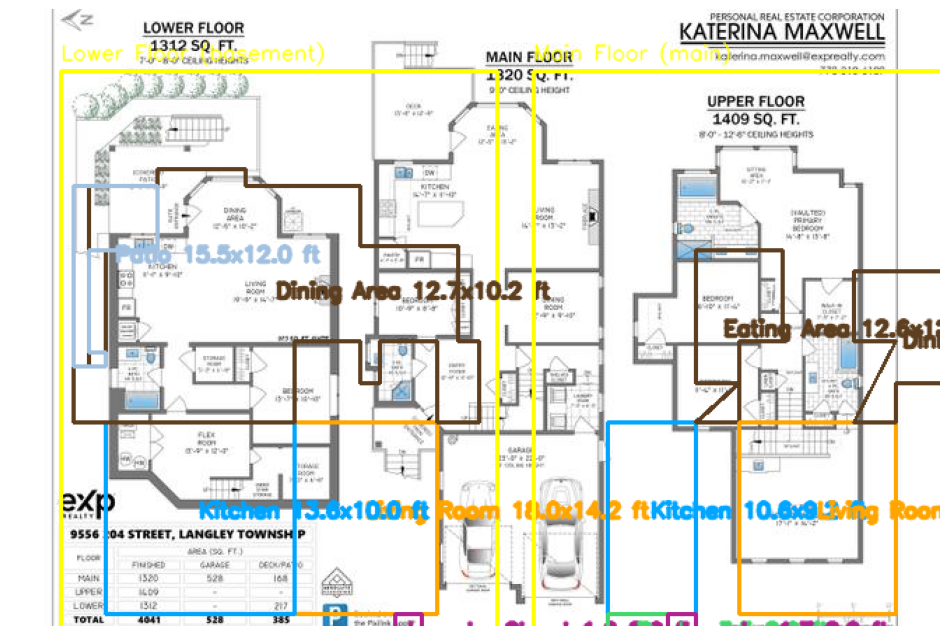

Floors detected: 3 | Plan type: multi_floor
  1. Lower Floor rooms: 13
  2. Main Floor rooms: 14
  3. Upper Floor rooms: 13
{
  "schema_version": "2.0",
  "image_info": {
    "width_px": 992,
    "height_px": 960,
    "orientation_deg": 0
  },
  "units": {
    "system": "imperial",
    "length_unit": "ft",
    "area_unit": "sqft",
    "scale_text": null
  },
  "floor_plan_type": "multi_floor",
  "total_floors_detected": 3,
  "floors": [
    {
      "floor_number": 0,
      "floor_name": "Lower Floor",
      "floor_type": "basement",
      "label_detected": "LOWER FLOOR",
      "detection_confidence": 1.0,
      "detection_reasoning": "Explicit 'LOWER FLOOR' label and context below 'MAIN FLOOR'.",
      "section_bbox": {
        "x_min": 36,
        "y_min": 44,
        "x_max": 348,
        "y_max": 864
      },
      "pixel_to_unit": {
        "pixels_per_foot": 12.0,
        "pixels_per_meter": 39.37,
        "inferred_from": "ocr_dimensions"
      },
      "walls": [
        {
     

In [6]:
# ...existing code...
# Run: analyze directly from image_path, visualize, and save. Fallback to widget if desired.

from pathlib import Path

# Option A: Use a file path (set this to your local image path)
image_path = r"C:\Users\ramma\Documents\augment-projects\augment\images\genMid.R2929648_1_4.jpg"  # e.g., r"..\\uploads\\floor_plans\\example_floorplan.jpg"

# Option B: Upload via widget (works in most Jupyter environments)
uploaded_path = None

# Choose execution mode
RUN_WITH_PATH = True  # set to False to use the upload widget

# Helper to standardize ipywidgets FileUpload across versions
# Supports tuple/list of UploadedFile objects, tuple/list of dicts, and legacy dict mapping
def _get_first_upload(upload):
    val = getattr(upload, "value", None)
    # Newer ipywidgets: tuple/list of UploadedFile or dicts
    if isinstance(val, (tuple, list)):
        if not val:
            return None
        item = val[0]
        if isinstance(item, dict):
            # Some envs provide a dict per file
            fname = item.get('name') or item.get('metadata', {}).get('name') or 'uploaded.bin'
            data = item.get('content') or item.get('data')
            return {"name": fname, "content": data}
        else:
            # UploadedFile object with attributes
            fname = getattr(item, 'name', 'uploaded.bin')
            data = getattr(item, 'content', None)
            if data is None:
                data = getattr(item, 'data', None)
            return {"name": fname, "content": data}
    # Legacy: dict mapping (guard against non-dict)
    if isinstance(val, dict) and hasattr(val, "values") and val:
        first_item = next(iter(val.values()))
        if isinstance(first_item, dict):
            fname = first_item.get('name') or first_item.get('metadata', {}).get('name') or 'uploaded.bin'
            data = first_item.get('content') or first_item.get('data')
            return {"name": fname, "content": data}
    return None

def run_analysis(target_path: str):
    print(f"Analyzing: {target_path}")
    start = time.time()
    result = call_gemini_and_parse(target_path, multi_floor_prompt)
    dur = time.time() - start
    print(f"Parsing & validation: OK (took {dur:.1f}s)")

    out_json = save_results(result, target_path)
    print(f"Saved results to: {out_json}")

    # Visualize detections
    visualize_results(target_path, result)

    # Quick summary + compact JSON preview
    floors = result.get('floors', [])
    print(f"Floors detected: {len(floors)} | Plan type: {result.get('floor_plan_type')}")
    for i, fl in enumerate(floors, 1):
        print(f"  {i}. {fl.get('floor_name')} rooms: {len(fl.get('rooms', []))}")
    try:
        preview = json.dumps(result, indent=2, ensure_ascii=False)
        print(preview[:4000] + ("...\n[truncated]" if len(preview) > 4000 else ""))
    except Exception:
        pass

if RUN_WITH_PATH:
    if not image_path:
        raise ValueError("image_path is empty. Set a valid path.")
    if not Path(image_path).exists():
        raise FileNotFoundError(f"File not found: {image_path}")
    run_analysis(image_path)
else:
    if HAVE_WIDGETS:
        upload = widgets.FileUpload(accept='image/*', multiple=False)
        analyze_btn = widgets.Button(description='Analyze', button_style='primary')
        status = widgets.Output()

        def on_analyze_clicked(_):
            global uploaded_path
            with status:
                clear_output()
                try:
                    file_info = _get_first_upload(upload)
                    if file_info and file_info.get('content'):
                        # Save uploaded file to OUTPUT_DIR/_uploads
                        fname = file_info['name']
                        data = file_info['content']
                        tmp_dir = OUTPUT_DIR / "_uploads"
                        tmp_dir.mkdir(parents=True, exist_ok=True)
                        uploaded_path = str(tmp_dir / fname)
                        with open(uploaded_path, 'wb') as f:
                            f.write(data)
                        print(f"Uploaded file saved to: {uploaded_path}")
                        target_path = uploaded_path
                    elif image_path and Path(image_path).exists():
                        target_path = image_path
                    else:
                        print("Please upload an image or set image_path to a valid file.")
                        return

                    run_analysis(target_path)
                except Exception as e:
                    print(f"Error: {e}")

        display(widgets.VBox([widgets.HTML("<b>Upload a floor plan image (PNG/JPG):</b>"), upload, analyze_btn, status]))
        analyze_btn.on_click(on_analyze_clicked)
    else:
        if not image_path:
            raise ValueError("Set 'image_path' to a valid floor plan image path, or run with ipywidgets available.")
        if not Path(image_path).exists():
            raise FileNotFoundError(f"File not found: {image_path}")
        run_analysis(image_path)
# ...existing code...

Analyzing with models: gemini-2.5-flash, gemini-2.5-pro
[gemini-2.5-flash] Parsing & validation: OK (took 143.8s)
[gemini-2.5-flash] Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-flash_20251102_111958.json
[gemini-2.5-flash] Parsing & validation: OK (took 143.8s)
[gemini-2.5-flash] Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-flash_20251102_111958.json
[gemini-2.5-pro] Parsing & validation: OK (took 83.3s)
[gemini-2.5-pro] Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-pro_20251102_112121.json
[gemini-2.5-pro] Parsing & validation: OK (took 83.3s)
[gemini-2.5-pro] Saved results to: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-pro_20251102_112121.json


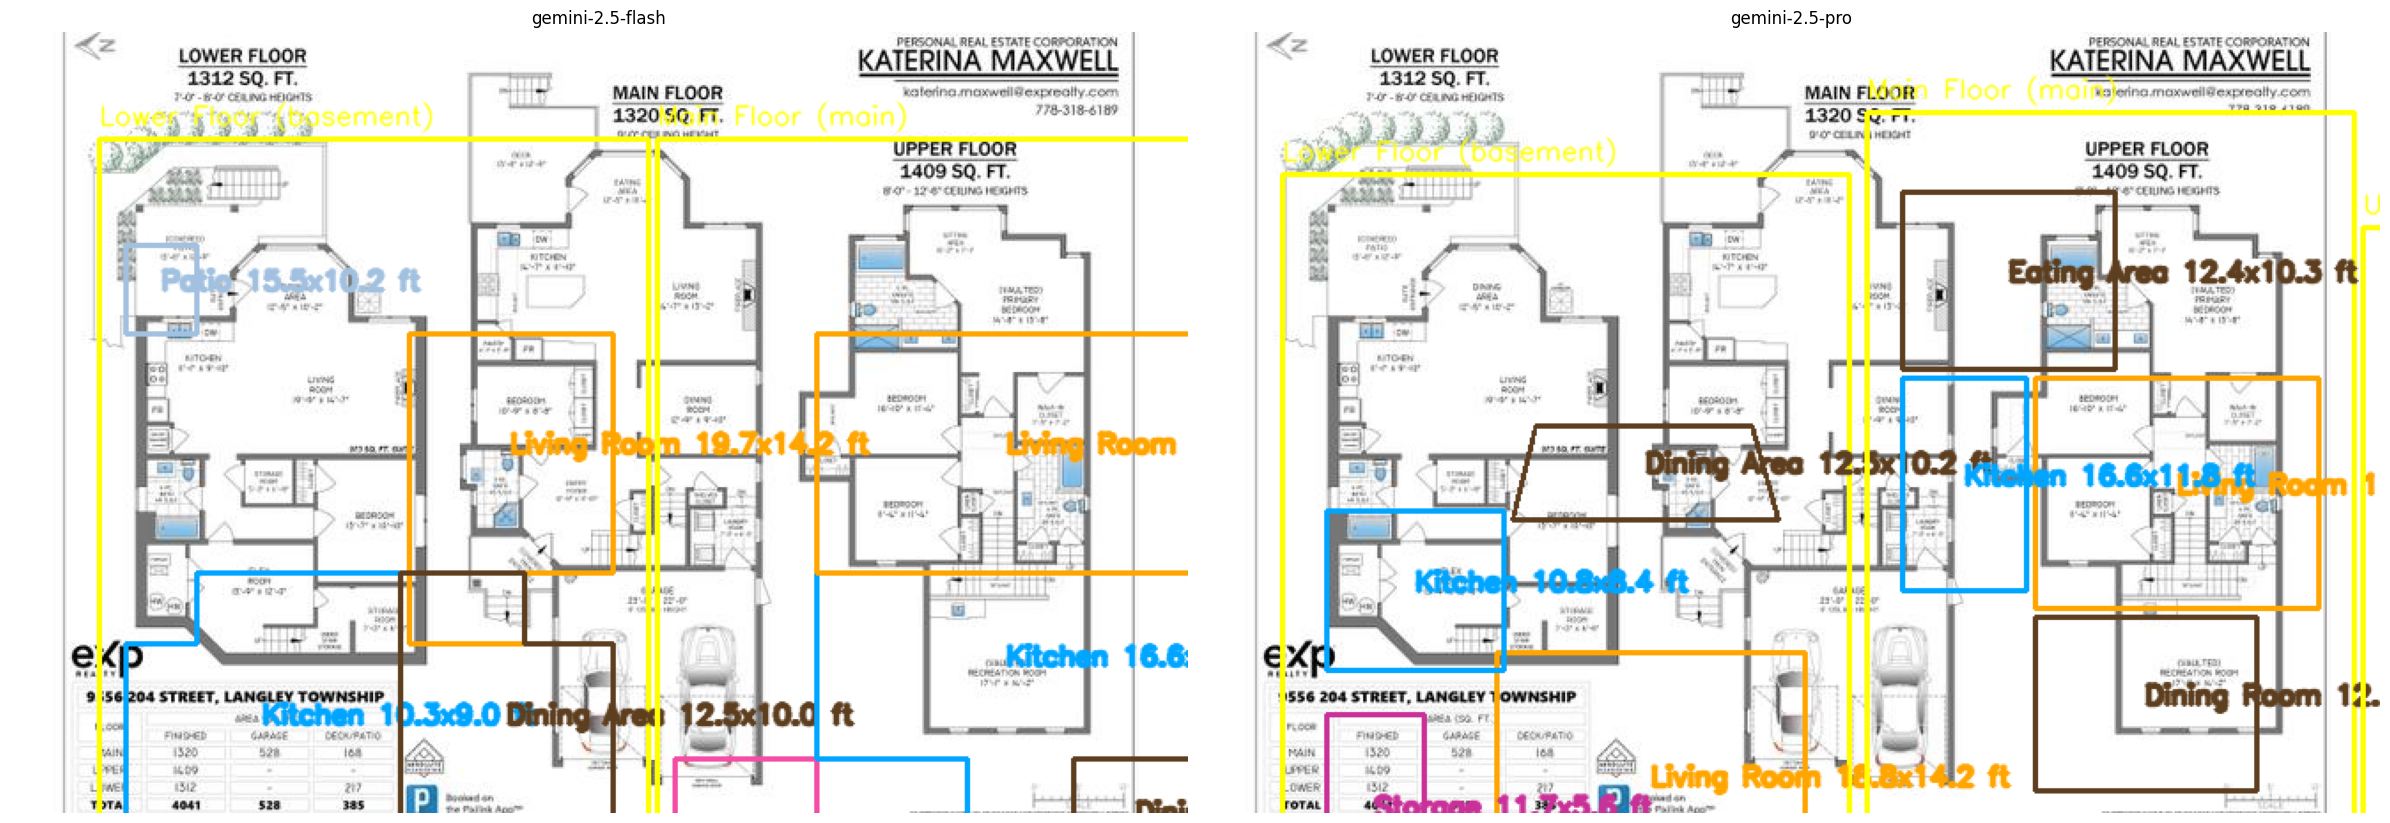


=== gemini-2.5-flash | Summary ===
Units: imperial | Floors: 3 | Rooms: 26 | Type: multi_floor
{
  "schema_version": "2.0",
  "image_info": {
    "width_px": 1000,
    "height_px": 987,
    "orientation_deg": 0
  },
  "units": {
    "system": "imperial",
    "length_unit": "ft",
    "area_unit": "sqft",
    "scale_text": null
  },
  "floor_plan_type": "multi_floor",
  "total_floors_detected": 3,
  "floors": [
    {
      "floor_number": 0,
      "floor_name": "Lower Floor",
      "floor_type": "basement",
      "label_detected": "LOWER FLOOR",
      "detection_confidence": 0.98,
      "detection_reasoning": "Explicit 'LOWER FLOOR' label; typical basement features like patio access and flex/storage rooms.",
      "section_bbox": {
        "x_min": 50,
        "y_min": 60,
        "x_max": 360,
        "y_max": 820
      },
      "pixel_to_unit": {
        "pixels_per_foot": 24.0,
        "pixels_per_meter": 78.74,
        "inferred_from": "door|tub|room_dimensions"
      },
      "wall

In [7]:
# ...existing code...
# Run & Compare: analyze with Gemini 2.5 Flash and 2.5 Pro, visualize, and save.

from pathlib import Path
import os

# Option A: Use a file path (set this to your local image path)
image_path = r"C:\Users\ramma\Documents\augment-projects\augment\images\genMid.R2929648_1_4.jpg"  # e.g., r"..\\uploads\\floor_plans\\example_floorplan.jpg"

# Option B: Upload via widget (works in most Jupyter environments)
uploaded_path = None

# Choose execution mode
RUN_WITH_PATH = True  # set to False to use the upload widget

# Models to compare (override via env if desired)
MODELS = [
    os.getenv("GEMINI_MODEL_FLASH", "gemini-2.5-flash"),
    os.getenv("GEMINI_MODEL_PRO", "gemini-2.5-pro"),
]

def _slug(s: str) -> str:
    return (s or "model").lower().replace(":", "_").replace("/", "_").replace(".", "-")

# Helper to standardize ipywidgets FileUpload across versions
# Supports tuple/list of UploadedFile objects, tuple/list of dicts, and legacy dict mapping
def _get_first_upload(upload):
    val = getattr(upload, "value", None)
    # Newer ipywidgets: tuple/list of UploadedFile or dicts
    if isinstance(val, (tuple, list)):
        if not val:
            return None
        item = val[0]
        if isinstance(item, dict):
            # Some envs provide a dict per file
            fname = item.get('name') or item.get('metadata', {}).get('name') or 'uploaded.bin'
            data = item.get('content') or item.get('data')
            return {"name": fname, "content": data}
        else:
            # UploadedFile object with attributes
            fname = getattr(item, 'name', 'uploaded.bin')
            data = getattr(item, 'content', None)
            if data is None:
                data = getattr(item, 'data', None)
            return {"name": fname, "content": data}
    # Legacy: dict mapping (guard against non-dict)
    if isinstance(val, dict) and hasattr(val, "values") and val:
        first_item = next(iter(val.values()))
        if isinstance(first_item, dict):
            fname = first_item.get('name') or first_item.get('metadata', {}).get('name') or 'uploaded.bin'
            data = first_item.get('content') or first_item.get('data')
            return {"name": fname, "content": data}
    return None

# Render visualization to an RGB numpy array (side-by-side plotting helper)
def render_visualization(image_path: str, result: Dict[str, Any], show_sections: bool = True, show_rooms: bool = True):
    img = cv2.imread(image_path)
    if img is None:
        raise RuntimeError(f"Failed to read image for visualization: {image_path}")
    vis = img.copy()

    for floor in result.get("floors", []):
        # Section bbox
        if show_sections and isinstance(floor.get("section_bbox"), dict):
            bb = floor["section_bbox"]
            x1, y1, x2, y2 = int(bb["x_min"]), int(bb["y_min"]), int(bb["x_max"]), int(bb["y_max"])
            cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 255), 2)
            label = f"{floor.get('floor_name', '')} ({floor.get('floor_type','')})"
            cv2.putText(vis, label, (x1, max(0, y1 - 8)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)

        # Rooms polygons
        if show_rooms:
            for room in floor.get("rooms", []):
                poly = room.get("polygon")
                name = room.get("name") or room.get("room_type") or "room"
                if poly and isinstance(poly, list) and len(poly) >= 3:
                    pts = np.array([[int(x), int(y)] for x, y in poly], dtype=np.int32)
                    color = _color_for(room.get("room_type", name))
                    cv2.polylines(vis, [pts], True, color, 2)
                    c = room.get("centroid") or {}
                    cx, cy = int(c.get("x", pts[:,0].mean())), int(c.get("y", pts[:,1].mean()))
                    text = name
                    dims = room.get("measured_dimensions", {})
                    if dims and isinstance(dims, dict):
                        L = dims.get("length", {})
                        W = dims.get("width", {})
                        if L.get("value") and W.get("value"):
                            text += f" {L['value']:.1f}x{W['value']:.1f} {L.get('unit','')}"
                    cv2.putText(vis, text, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)

    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    return vis_rgb

# Call Gemini with a specific model name and parse
def call_gemini_and_parse_with_model(image_path: str, prompt: str, model_name: str) -> Dict[str, Any]:
    img_bytes, mime = read_image_bytes(image_path)
    mdl = genai.GenerativeModel(model_name)
    inputs = [prompt, {"mime_type": mime, "data": img_bytes}]
    response = mdl.generate_content(inputs)
    text = response.text or ""
    result = extract_json(text)
    light_validate(result)
    return result

# Save results with a model suffix to avoid collisions
def save_results_with_suffix(result: Dict[str, Any], image_path: str, model_name: str) -> Path:
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    base = Path(image_path).stem
    model_tag = _slug(model_name)
    out_json = OUTPUT_DIR / f"{base}_analysis_{model_tag}_{ts}.json"
    with open(out_json, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2)
    return out_json

def _totals_summary(res: Dict[str, Any]) -> Dict[str, Any]:
    floors = res.get("floors", [])
    rooms_total = sum(len(f.get("rooms", [])) for f in floors)
    return {
        "plan_type": res.get("floor_plan_type"),
        "floors": len(floors),
        "rooms_total": rooms_total,
        "units": res.get("units", {}).get("system"),
    }

def run_analysis_multi(target_path: str, models: list[str] = None):
    models = models or MODELS
    print(f"Analyzing with models: {', '.join(models)}")
    results = {}
    visuals = {}
    summaries = {}

    for m in models:
        try:
            start = time.time()
            res = call_gemini_and_parse_with_model(target_path, multi_floor_prompt, m)
            dur = time.time() - start
            print(f"[{m}] Parsing & validation: OK (took {dur:.1f}s)")
            results[m] = res
            summaries[m] = _totals_summary(res)
            out_json = save_results_with_suffix(res, target_path, m)
            print(f"[{m}] Saved results to: {out_json}")
            visuals[m] = render_visualization(target_path, res)
        except Exception as e:
            print(f"[{m}] Error: {e}")

    # Side-by-side visualization (if we have at least one)
    try:
        ms = list(visuals.keys())
        if len(ms) == 1:
            plt.figure(figsize=(12, 12))
            plt.imshow(visuals[ms[0]])
            plt.title(ms[0])
            plt.axis("off")
            plt.show()
        elif len(ms) >= 2:
            cols = 2
            rows = (len(ms) + 1) // 2
            plt.figure(figsize=(12*cols, 10*rows))
            for i, m in enumerate(ms, 1):
                plt.subplot(rows, cols, i)
                plt.imshow(visuals[m])
                plt.title(m)
                plt.axis("off")
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Visualization error: {e}")

    # Compact JSON preview and comparison summary
    for m, res in results.items():
        try:
            preview = json.dumps(res, indent=2, ensure_ascii=False)
            print(f"\n=== {m} | Summary ===")
            print(f"Units: {summaries[m]['units']} | Floors: {summaries[m]['floors']} | Rooms: {summaries[m]['rooms_total']} | Type: {summaries[m]['plan_type']}")
            print(preview[:2000] + ("...\n[truncated]" if len(preview) > 2000 else ""))
        except Exception:
            pass

    if len(summaries) >= 2:
        print("\n=== Quick diff (floors, total rooms) ===")
        base_m = list(summaries.keys())[0]
        for m in summaries.keys():
            s = summaries[m]
            print(f"{m}: floors={s['floors']}, rooms_total={s['rooms_total']}")

if RUN_WITH_PATH:
    if not image_path:
        raise ValueError("image_path is empty. Set a valid path.")
    if not Path(image_path).exists():
        raise FileNotFoundError(f"File not found: {image_path}")
    run_analysis_multi(image_path, MODELS)
else:
    if HAVE_WIDGETS:
        upload = widgets.FileUpload(accept='image/*', multiple=False)
        analyze_btn = widgets.Button(description='Analyze (Compare Models)', button_style='primary')
        status = widgets.Output()

        def on_analyze_clicked(_):
            global uploaded_path
            with status:
                clear_output()
                try:
                    file_info = _get_first_upload(upload)
                    if file_info and file_info.get('content'):
                        # Save uploaded file to OUTPUT_DIR/_uploads
                        fname = file_info['name']
                        data = file_info['content']
                        tmp_dir = OUTPUT_DIR / "_uploads"
                        tmp_dir.mkdir(parents=True, exist_ok=True)
                        uploaded_path = str(tmp_dir / fname)
                        with open(uploaded_path, 'wb') as f:
                            f.write(data)
                        print(f"Uploaded file saved to: {uploaded_path}")
                        target_path = uploaded_path
                    elif image_path and Path(image_path).exists():
                        target_path = image_path
                    else:
                        print("Please upload an image or set image_path to a valid file.")
                        return

                    run_analysis_multi(target_path, MODELS)
                except Exception as e:
                    print(f"Error: {e}")

        display(widgets.VBox([widgets.HTML("<b>Upload a floor plan image (PNG/JPG):</b>"), upload, analyze_btn, status]))
        analyze_btn.on_click(on_analyze_clicked)
    else:
        if not image_path:
            raise ValueError("Set 'image_path' to a valid floor plan image path, or run with ipywidgets available.")
        if not Path(image_path).exists():
            raise FileNotFoundError(f"File not found: {image_path}")
        run_analysis_multi(image_path, MODELS)
# ...existing code...

Comparing:
- Flash: ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-flash_20251102_111958.json
- Pro:   ..\uploads\floor_plans\analysis\genMid.R2929648_1_4_analysis_gemini-2-5-pro_20251102_112121.json

[gemini-2.5-flash] score=4.3209
- plan_type=multi_floor | units=imperial
- floors=3 | rooms_total=26 | stairs=5
- polygons=1.00 | centroids=1.00
- scale_floors=3 | doors=12 | windows=8 | adjacency=26
- avg_room_conf=0.90 | avg_floor_conf=0.98
- ocr_dim_rooms=16 | estimated_rooms=0
- area_mean_abs_pct_err=0.25
- warnings=0 | errors=0

[gemini-2.5-pro] score=4.1256
- plan_type=multi_floor | units=imperial
- floors=3 | rooms_total=17 | stairs=3
- polygons=1.00 | centroids=1.00
- scale_floors=3 | doors=0 | windows=0 | adjacency=0
- avg_room_conf=0.98 | avg_floor_conf=1.00
- ocr_dim_rooms=16 | estimated_rooms=0
- area_mean_abs_pct_err=0.26
- warnings=1 | errors=0

Winner: gemini-2.5-flash (pro=4.1256, flash=4.3209)

Top reasons:
- Flash better adjacency coverage (26 vs

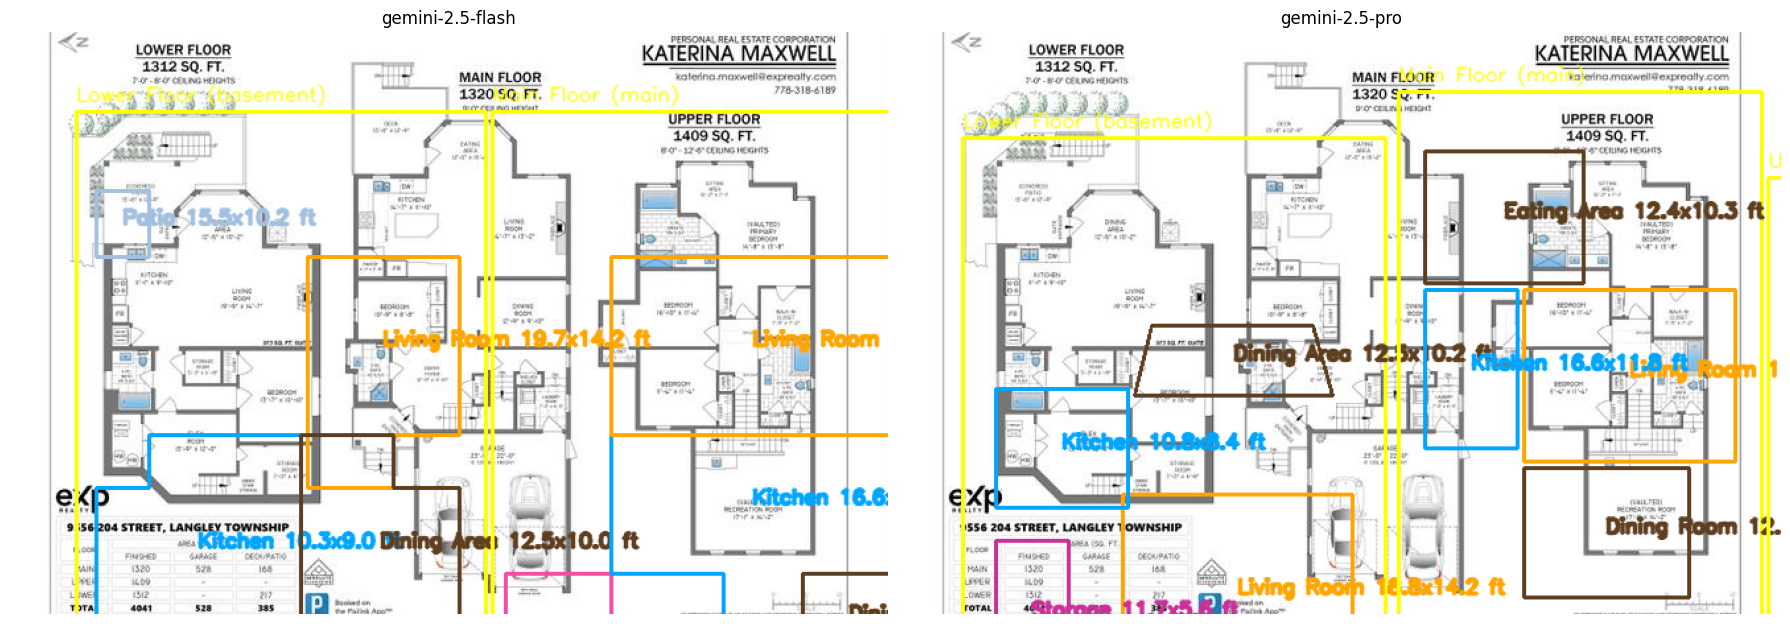

In [8]:
# ...existing code...
# Compare analysis results: Gemini 2.5 Flash vs 2.5 Pro

from pathlib import Path
import math

def _latest_result_for_model(base_stem: str, model_tag: str) -> Path:
    # Saved file pattern uses slug with dots -> dashes
    candidates = sorted(OUTPUT_DIR.glob(f"{base_stem}_analysis_{model_tag}_*.json"), key=lambda p: p.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError(f"No results found for model tag '{model_tag}' under {OUTPUT_DIR}")
    return candidates[0]

def _rooms(res):
    return [r for f in res.get("floors", []) for r in f.get("rooms", [])]

def _safe_num(x, default=0.0):
    try:
        return float(x)
    except Exception:
        return default

def _sum_room_areas(floor):
    total = 0.0
    unit = None
    for r in floor.get("rooms", []):
        md = r.get("measured_dimensions", {}) or {}
        area = md.get("area", {}) or {}
        v = area.get("value")
        u = area.get("unit")
        if v is not None:
            total += _safe_num(v, 0.0)
            unit = unit or u
    return total, unit

def extract_metrics(res: Dict[str, Any]) -> Dict[str, Any]:
    floors = res.get("floors", []) or []
    rooms = _rooms(res)

    floors_with_scale = 0
    doors = windows = stairs = 0
    warnings_total = errors_total = adjacency_total = 0
    floor_conf_sum = 0.0
    floor_conf_n = 0
    rooms_with_poly = 0
    rooms_with_centroid = 0
    room_conf_sum = 0.0
    room_conf_n = 0
    ocr_dim_rooms = 0
    estimated_rooms = 0
    area_pct_errs = []

    for f in floors:
        # scale presence
        ptu = f.get("pixel_to_unit") or {}
        if ptu.get("pixels_per_foot") not in (None, 0) or ptu.get("pixels_per_meter") not in (None, 0):
            floors_with_scale += 1
        # counts
        doors += len(f.get("doors", []) or [])
        windows += len(f.get("windows", []) or [])
        stairs += len(f.get("stairs", []) or [])
        warnings_total += len(f.get("warnings", []) or [])
        errors_total += len(f.get("errors", []) or [])
        adjacency_total += len(f.get("adjacency", []) or [])
        # floor confidence
        if isinstance(f.get("detection_confidence"), (int, float)):
            floor_conf_sum += float(f["detection_confidence"])
            floor_conf_n += 1
        # area consistency per floor
        fa = f.get("floor_analysis", {}) or {}
        total_area = fa.get("total_area", {}) or {}
        tot_val = total_area.get("value")
        if tot_val not in (None, 0):
            floor_sum, floor_unit = _sum_room_areas(f)
            tval = _safe_num(tot_val, 0.0)
            if tval > 0:
                pct = abs(floor_sum - tval) / tval
                area_pct_errs.append(min(5.0, pct))  # cap to avoid exploding

    for r in rooms:
        poly = r.get("polygon")
        if isinstance(poly, list) and len(poly) >= 3:
            rooms_with_poly += 1
        c = r.get("centroid") or {}
        if c.get("x") is not None and c.get("y") is not None:
            rooms_with_centroid += 1
        if isinstance(r.get("confidence"), (int, float)):
            room_conf_sum += float(r["confidence"])
            room_conf_n += 1
        md = r.get("measured_dimensions", {}) or {}
        if md.get("estimated") is True:
            estimated_rooms += 1
        L = (md.get("length") or {}).get("source")
        W = (md.get("width") or {}).get("source")
        if L == "ocr" or W == "ocr":
            ocr_dim_rooms += 1

    rooms_total = len(rooms)
    floors_n = len(floors)
    metrics = {
        "floors": floors_n,
        "rooms_total": rooms_total,
        "room_polygon_ratio": (rooms_with_poly / rooms_total) if rooms_total else 0.0,
        "centroid_ratio": (rooms_with_centroid / rooms_total) if rooms_total else 0.0,
        "scale_floors_with_scale": floors_with_scale,
        "doors_total": doors,
        "windows_total": windows,
        "stairs_total": stairs,
        "warnings_total": warnings_total,
        "errors_total": errors_total,
        "adjacency_edges_total": adjacency_total,
        "avg_floor_confidence": (floor_conf_sum / floor_conf_n) if floor_conf_n else 0.0,
        "avg_room_confidence": (room_conf_sum / room_conf_n) if room_conf_n else 0.0,
        "ocr_dim_rooms": ocr_dim_rooms,
        "estimated_rooms": estimated_rooms,
        "area_consistency_mean_abs_pct": (sum(area_pct_errs) / len(area_pct_errs)) if area_pct_errs else 0.0,
        "units_system": (res.get("units") or {}).get("system"),
        "plan_type": res.get("floor_plan_type"),
    }
    return metrics

def score_metrics(m: Dict[str, Any]) -> float:
    rooms = max(1, m.get("rooms_total", 0))
    floors = max(1, m.get("floors", 0))
    score = 0.0
    # positives
    score += 2.0 * (m.get("scale_floors_with_scale", 0) / floors)
    score += 1.0 * m.get("room_polygon_ratio", 0.0)
    score += 0.3 * m.get("centroid_ratio", 0.0)
    score += 0.5 * m.get("avg_room_confidence", 0.0)
    score += 0.3 * m.get("avg_floor_confidence", 0.0)
    score += 0.2 * min(1.0, m.get("adjacency_edges_total", 0) / rooms)
    score += 0.2 * min(1.0, (m.get("doors_total", 0) + m.get("windows_total", 0)) / (rooms * 2))
    score += 0.2 * (m.get("ocr_dim_rooms", 0) / rooms)
    # negatives
    score -= 0.02 * m.get("warnings_total", 0)
    score -= 0.05 * m.get("errors_total", 0)
    score -= 0.5 * min(1.0, m.get("area_consistency_mean_abs_pct", 0.0))
    score -= 0.2 * min(1.0, m.get("estimated_rooms", 0) / rooms)
    return round(score, 4)

def _print_metrics(label: str, m: Dict[str, Any], s: float):
    print(f"\n[{label}] score={s}")
    print(f"- plan_type={m['plan_type']} | units={m['units_system']}")
    print(f"- floors={m['floors']} | rooms_total={m['rooms_total']} | stairs={m['stairs_total']}")
    print(f"- polygons={m['room_polygon_ratio']:.2f} | centroids={m['centroid_ratio']:.2f}")
    print(f"- scale_floors={m['scale_floors_with_scale']} | doors={m['doors_total']} | windows={m['windows_total']} | adjacency={m['adjacency_edges_total']}")
    print(f"- avg_room_conf={m['avg_room_confidence']:.2f} | avg_floor_conf={m['avg_floor_confidence']:.2f}")
    print(f"- ocr_dim_rooms={m['ocr_dim_rooms']} | estimated_rooms={m['estimated_rooms']}")
    print(f"- area_mean_abs_pct_err={m['area_consistency_mean_abs_pct']:.2f}")
    print(f"- warnings={m['warnings_total']} | errors={m['errors_total']}")

def _reason_deltas(mA, sA, mB, sB, nameA, nameB):
    # Heuristic reasons: list top metric advantages
    reasons = []
    def add(reason): 
        if reason: reasons.append(reason)
    # Higher is better metrics
    hi = [
        ("room_polygon_ratio", "room polygon coverage"),
        ("centroid_ratio", "centroid coverage"),
        ("avg_room_confidence", "room confidence"),
        ("avg_floor_confidence", "floor detection confidence"),
        ("adjacency_edges_total", "adjacency coverage"),
        ("ocr_dim_rooms", "rooms with OCR dimensions"),
        ("scale_floors_with_scale", "floors with scale resolved"),
        ("doors_total", "door detection"),
        ("windows_total", "window detection"),
    ]
    # Lower is better metrics
    lo = [
        ("errors_total", "fewer errors"),
        ("warnings_total", "fewer warnings"),
        ("area_consistency_mean_abs_pct", "area consistency"),
        ("estimated_rooms", "fewer estimated dims"),
    ]
    # Build simple ranked list
    diffs = []
    for k, label in hi:
        diffs.append((abs((mA.get(k,0)-mB.get(k,0))), k, label, "hi"))
    for k, label in lo:
        diffs.append((abs((mA.get(k,0)-mB.get(k,0))), k, label, "lo"))
    diffs.sort(reverse=True)
    for _, k, label, kind in diffs[:5]:
        a, b = mA.get(k,0), mB.get(k,0)
        if kind == "hi":
            if a > b: add(f"{nameA} better {label} ({a} vs {b})")
            elif b > a: add(f"{nameB} better {label} ({b} vs {a})")
        else:
            if a < b: add(f"{nameA} better {label} ({a} vs {b})")
            elif b < a: add(f"{nameB} better {label} ({b} vs {a})")
    return list(dict.fromkeys(reasons))  # de-dup

# Identify latest outputs for the current image
base_stem = Path(image_path).stem
flash_tag = "gemini-2-5-flash"
pro_tag   = "gemini-2-5-pro"

flash_path = _latest_result_for_model(base_stem, flash_tag)
pro_path   = _latest_result_for_model(base_stem, pro_tag)

print(f"Comparing:\n- Flash: {flash_path}\n- Pro:   {pro_path}")

with open(flash_path, "r", encoding="utf-8") as f:
    res_flash = json.load(f)
with open(pro_path, "r", encoding="utf-8") as f:
    res_pro = json.load(f)

m_flash = extract_metrics(res_flash)
m_pro   = extract_metrics(res_pro)

s_flash = score_metrics(m_flash)
s_pro   = score_metrics(m_pro)

_print_metrics("gemini-2.5-flash", m_flash, s_flash)
_print_metrics("gemini-2.5-pro",   m_pro,   s_pro)

winner = "gemini-2.5-pro" if s_pro > s_flash else ("gemini-2.5-flash" if s_flash > s_pro else "tie")
print(f"\nWinner: {winner} (pro={s_pro}, flash={s_flash})")

reasons = _reason_deltas(m_pro, s_pro, m_flash, s_flash, "Pro", "Flash")
if reasons:
    print("\nTop reasons:")
    for r in reasons:
        print(f"- {r}")

# Optional: side-by-side visualization from the already loaded results
try:
    vis_pro = render_visualization(image_path, res_pro)
    vis_flash = render_visualization(image_path, res_flash)
    plt.figure(figsize=(18, 8))
    plt.subplot(1, 2, 1); plt.imshow(vis_flash); plt.title("gemini-2.5-flash"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(vis_pro);   plt.title("gemini-2.5-pro");   plt.axis("off")
    plt.tight_layout(); plt.show()
except Exception as e:
    print(f"Visualization note: {e}")
# ...existing code...